<a href="https://colab.research.google.com/github/asdflazaro/Cow_Science_Robots/blob/main/C%C3%B3digo_Doutorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Parte 0 - Downloads e imports principais**

In [29]:
#Baixar e instalar o skopt
!pip install scikit-learn==1.0.0 -q -U
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
# Imports
import numpy as np
import pandas as pd
import skopt

**Parte 1 - Leitura dos dados**

In [32]:
# Leitura e amostra da tabela
df = pd.read_csv('Tabela.P.D.csv', delimiter = ';')
df.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:01,11130,7025,7761,-2178,-1819,2134,1
2,27/01/2023,04:45:02,10120,6610,10145,-2487,185,1868,1
3,27/01/2023,04:45:03,13629,3053,7777,-837,-4725,-3067,1
4,27/01/2023,04:45:04,13537,3296,7080,1245,-2580,571,1


In [33]:
# Exibe os tipos presentes na tabela
df.dtypes

Data             object
Hora             object
ax                int64
ay                int64
az                int64
gx                int64
gy                int64
gz                int64
Comportamento     int64
dtype: object

**Parte 2 - Treinamento e validação**

In [38]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

Seleção de colunas aplicáveis

In [39]:
# Exibe as colunas existentes
df.columns

Index(['ax', 'ay', 'az', 'gx', 'gy', 'gz ', 'Comportamento'], dtype='object')

In [40]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'gx', 'gy', 'gz ', 'Comportamento']

In [41]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

Função para imprimir a quantidade de dados por conjunto

In [42]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [43]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

Quantidade de dados por conjunto

In [44]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  62896
Teste:  15725
-------------------------------------------


Função para imprimir e salvar matriz de confusão

In [47]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [48]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

▶ **Light Gradient Boosting - LGBMClassifier**


In [49]:
from lightgbm import LGBMClassifier

In [50]:
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

90.18759936406995

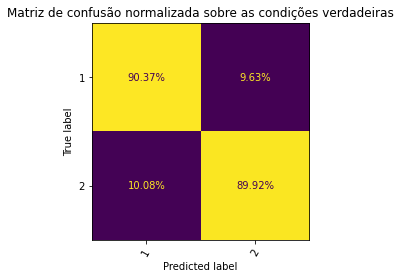

In [51]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [52]:
print(classification_report(y_test, lgb_preds))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92      9357
           2       0.86      0.90      0.88      6368

    accuracy                           0.90     15725
   macro avg       0.90      0.90      0.90     15725
weighted avg       0.90      0.90      0.90     15725



⚓ LGB: Busca de melhores hiper parâmetros

In [53]:
def tune_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100, n_jobs=-1)
    
    auc = cross_val_score(lgb_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [54]:
%%time
resultados_lgb = gp_minimize(tune_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 433, 429, 0.8548891518449193, 0.6612073271073752] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.1057
Function value obtained: -0.8839
Current minimum: -0.8839
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 154, 29, 0.30902347985110756, 0.529898605589215] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.4157
Function value obtained: -0.8748
Current minimum: -0.8839
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 247, 197, 0.8442748253605089, 0.40365654437554166] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.5922
Function value obtained: -0.8916
Current minimum: -0.8916
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 190, 479, 0.1833332413920129, 0.8830785325225929] 

Iteration No: 4 ended. Evaluation done at random point.

In [55]:
# Retorna os melhores hiperparametros 
# Eles devem ser escritos manualmente mais pra frente
# Em ordem: learning_rate, num_leaves, min_child_samples, subsample, colsample_bytree
resultados_lgb.x

[0.04645762770878556, 512, 1, 1.0, 0.9179509403571726]

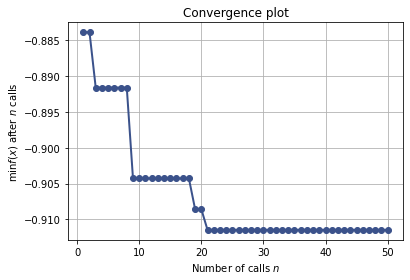

In [56]:
# Gera um gráfico dos melhores hiperparametros
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

Treinamento com os melhores hiperparametros

In [68]:
# Observar os melhores hiperparametros e adiciona-los manualmente
# Retorna a acurácia e o tempo gasto pelo PC
%%time
lgb_model = LGBMClassifier(learning_rate=0.046, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.918, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

CPU times: user 5.94 s, sys: 216 ms, total: 6.16 s
Wall time: 3.19 s


90.81081081081082

In [60]:
# classification_report_extendido(y_test, lgb_preds)
# ERRRRRROOOOO

In [69]:
# Retorna a tabela com a acurácia, precisão, sensitividade e F1-Score
# O digits= determina a quantidade de casas após a virgula
print(classification_report(y_test, lgb_preds, digits=5))

              precision    recall  f1-score   support

           1    0.92611   0.91888   0.92248      9357
           2    0.88216   0.89227   0.88719      6368

    accuracy                        0.90811     15725
   macro avg    0.90414   0.90558   0.90484     15725
weighted avg    0.90831   0.90811   0.90819     15725



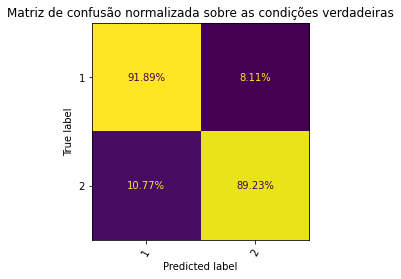

In [70]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [ ]:
#### Perguntar ao Caio como colocar as outras métricas

**▶ RF - Random Forest**


In [80]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [81]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [83]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [84]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [85]:
# Identificação do melhor hiperparametro para testes iniciais
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

CPU times: user 51.6 s, sys: 2.92 s, total: 54.5 s
Wall time: 8min 9s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [50, 100, 150, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10, 30, 50],
                                        'n_estimators': array([ 50, 100, 150, 200])},
                   random_state=0, verbose=1)

In [86]:
# Retorna o melhor hiperparametro
rf_RandomGrid.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': False}

In [87]:
# Acurácia com o melhor hiperparametro pata teste inicial
rf_RandomGrid.best_score_

0.9102804674912437

In [88]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [89]:
accuracy_score(y_test, preds_rf_RG)*100

90.88712241653418

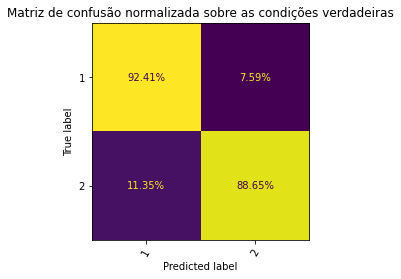

In [90]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

⚓ RF: Busca de melhores hiper parâmetros

In [91]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [92]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 79.4511
Function value obtained: -0.9102
Current minimum: -0.9102
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.5646
Function value obtained: -0.9085
Current minimum: -0.9102
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 40.1127
Function value obtained: -0.9100
Current minimum: -0.9102
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 39.0837
Function value obtained: -0.9097
Current minimum: -0.9102
Iteration No: 5 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 5, 1, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 21.0439
Function value obtained: -0.9103
Current minimum: -0.9103
Iteration No: 6 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 13.2897
Function value obtained: -0.9085
Current minimum: -0.9103
Iteration No: 7 started. Evaluating function at random point.
[50, 'sqrt', 150, 'entropy', 5, 4, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.8975
Function value obtained: -0.9090
Current minimum: -0.9103
Iteration No: 8 started. Evaluating function at random point.
[100, 'auto', 150, 'gini', 30, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 27.6174
Function value obtained: -0.9065
Current minimum: -0.9103
Iteration No: 9 started. Evaluating function at random point.
[150, 'auto', 100, 'gini', 5, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 62.6991
Function value obtained: -0.9102
Current minimum: -0.9103
Iteration No: 10 started. Evaluating function at random point.
[150, 'sqrt', 150, 'entropy', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 47.0086
Function value obtained: -0.9099
Current minimum: -0.9103
Iteration No: 11 started. Evaluating function at random point.
[200, 'sqrt', 50, 'entropy', 2, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 60.5559
Function value obtained: -0.9104
Current minimum: -0.9104
Iteration No: 12 started. Evaluating function at random point.
[100, 'auto', 150, 'gini', 50, 1, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 25.3363
Function value obtained: -0.9044
Current minimum: -0.9104
Iteration No: 13 started. Evaluating function at random point.
[200, 'sqrt', None, 'gini', 2, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 82.8772
Function value obtained: -0.9108
Current minimum: -0.9108
Iteration No: 14 started. Evaluating function at random point.
[200, 'sqrt', None, 'entropy', 10, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 14 ended. Evaluation done at random point.
Time taken: 94.7334
Function value obtained: -0.9108
Current minimum: -0.9108
Iteration No: 15 started. Evaluating function at random point.
[100, 'auto', 150, 'gini', 5, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 27.3572
Function value obtained: -0.9098
Current minimum: -0.9108
Iteration No: 16 started. Searching for the next optimal point.
[100, 'auto', 100, 'entropy', 2, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 47.4590
Function value obtained: -0.9109
Current minimum: -0.9109
Iteration No: 17 started. Searching for the next optimal point.
[150, 'auto', 150, 'gini', 2, 1, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 41.6477
Function value obtained: -0.9108
Current minimum: -0.9109
Iteration No: 18 started. Searching for the next optimal point.
[50, 'auto', 100, 'entropy', 50, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 23.1007
Function value obtained: -0.9070
Current minimum: -0.9109
Iteration No: 19 started. Searching for the next optimal point.
[150, 'auto', 50, 'entropy', 30, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 67.3563
Function value obtained: -0.9090
Current minimum: -0.9109
Iteration No: 20 started. Searching for the next optimal point.
[100, 'auto', 100, 'entropy', 10, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 32.5968
Function value obtained: -0.9092
Current minimum: -0.9109
Iteration No: 21 started. Searching for the next optimal point.
[200, 'sqrt', 150, 'gini', 5, 4, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 52.5157
Function value obtained: -0.9092
Current minimum: -0.9109
Iteration No: 22 started. Searching for the next optimal point.
[200, 'sqrt', 100, 'gini', 50, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 74.7677
Function value obtained: -0.9062
Current minimum: -0.9109
Iteration No: 23 started. Searching for the next optimal point.
[50, 'auto', None, 'gini', 2, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 21.6163
Function value obtained: -0.9094
Current minimum: -0.9109
Iteration No: 24 started. Searching for the next optimal point.
[50, 'sqrt', 150, 'gini', 30, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 19.7288
Function value obtained: -0.9075
Current minimum: -0.9109
Iteration No: 25 started. Searching for the next optimal point.
[200, 'sqrt', 50, 'entropy', 10, 4, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 91.7611
Function value obtained: -0.9105
Current minimum: -0.9109
Iteration No: 26 started. Searching for the next optimal point.
[200, 'sqrt', None, 'entropy', 30, 1, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 88.9829
Function value obtained: -0.9093
Current minimum: -0.9109
Iteration No: 27 started. Searching for the next optimal point.
[150, 'sqrt', None, 'entropy', 50, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 43.4028
Function value obtained: -0.9055
Current minimum: -0.9109
Iteration No: 28 started. Searching for the next optimal point.
[50, 'auto', 50, 'entropy', 5, 1, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 24.4762
Function value obtained: -0.9096
Current minimum: -0.9109
Iteration No: 29 started. Searching for the next optimal point.
[100, 'sqrt', 50, 'gini', 2, 2, True] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 26.8541
Function value obtained: -0.9098
Current minimum: -0.9109
Iteration No: 30 started. Searching for the next optimal point.
[200, 'sqrt', 150, 'entropy', 2, 2, False] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  "https://scikit-learn.org/stable/modules/model_persistence"
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier fro

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 91.5871
Function value obtained: -0.9102
Current minimum: -0.9109
CPU times: user 1min 57s, sys: 14 s, total: 2min 11s
Wall time: 23min 19s


In [93]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[100, 'auto', 100, 'entropy', 2, 4, False]

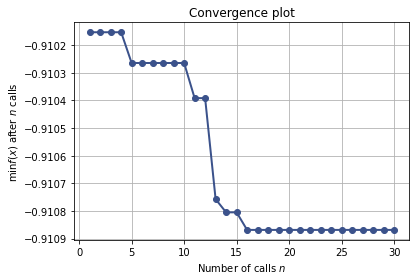

In [94]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

Treinamento com os melhores hiperparâmetros


In [95]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=100, criterion='entropy',
                                  min_samples_split=2, min_samples_leaf=4 , bootstrap=False, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 38.6 s, sys: 57.9 ms, total: 38.7 s
Wall time: 23.3 s


In [97]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

90.86168521462639

In [99]:
### classification_report_extendido(y_test, preds)
# Não consigo acessar todos os resultados - ver com o Caio

In [100]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           1    0.92581   0.92017   0.92298      9357
           2    0.88374   0.89165   0.88767      6368

    accuracy                        0.90862     15725
   macro avg    0.90477   0.90591   0.90533     15725
weighted avg    0.90877   0.90862   0.90868     15725



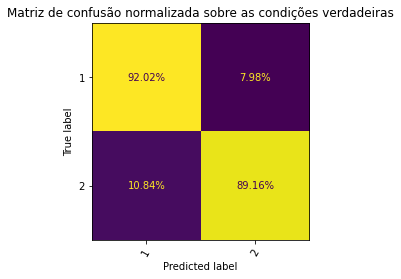

In [101]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

**▶ GB - Gradient Boosting**


In [102]:
# Imports
from xgboost import XGBClassifier

In [103]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))
y_test_ordinal = ordinal_encoder.transform(y_test.array.reshape(-1,1))

In [104]:
xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(use_label_encoder=False)

In [106]:
# Acurácia do primeiro teste
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)*100

87.77106518282989

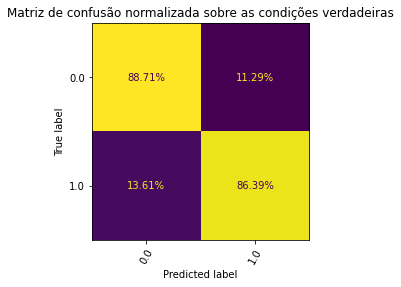

In [107]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

⚓ GB: Busca de melhores hiper parâmetros

In [108]:
def tune_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(gb_Model, X_train, y_train_ordinal, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 16), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [109]:
%%time
resultados_gb = gp_minimize(tune_gb, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 14, 14, 0.4236258693920628, 0.6612073271073752] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.8259
Function value obtained: -0.8995
Current minimum: -0.8995
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 6, 2, 0.13632814729005663, 0.529898605589215] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.5758
Function value obtained: -0.8831
Current minimum: -0.8995
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 9, 7, 0.4180393817686889, 0.40365654437554166] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.3056
Function value obtained: -0.8932
Current minimum: -0.8995
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 7, 15, 0.07017539020632259, 0.8830785325225929] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.9732
Function value obtained: -0.8946
Current minimum: -0.8995
Iteration No: 5 started. Evaluating function at random point.
[0.008855561236207114, 13, 9, 0.3394397650594802, 0.7485693892533252] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 26.1019
Function value obtained: -0.9015
Current minimum: -0.9015
Iteration No: 6 started. Evaluating function at random point.
[0.014589472312361858, 10, 12, 0.05295380359389608, 0.5262403774119918] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.5513
Function value obtained: -0.8977
Current minimum: -0.9015
Iteration No: 7 started. Evaluating function at random point.
[0.002358656440793903, 12, 4, 0.06760908670272604, 0.3917269070138928] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 15.9594
Function value obtained: -0.8766
Current minimum: -0.9015
Iteration No: 8 started. Evaluating function at random point.
[0.0019922770602188436, 5, 7, 0.45129923776470243, 0.504954990920105] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.0108
Function value obtained: -0.8711
Current minimum: -0.9015
Iteration No: 9 started. Evaluating function at random point.
[0.0168316586809914, 15, 2, 0.4849045338733745, 0.687826032218144] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 32.1359
Function value obtained: -0.9069
Current minimum: -0.9069
Iteration No: 10 started. Evaluating function at random point.
[0.0021969449275369667, 7, 12, 0.30391533435773394, 0.3925425061075173] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.4239
Function value obtained: -0.8714
Current minimum: -0.9069
Iteration No: 11 started. Searching for the next optimal point.
[0.1, 16, 1, 0.021169454731254717, 0.8000790582626353] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 34.1242
Function value obtained: -0.9103
Current minimum: -0.9103
Iteration No: 12 started. Searching for the next optimal point.
[0.04530703017735834, 16, 1, 0.0, 1.0] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 46.0691
Function value obtained: -0.9090
Current minimum: -0.9103
Iteration No: 13 started. Searching for the next optimal point.
[0.1, 16, 16, 0.5, 1.0] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 33.5006
Function value obtained: -0.9078
Current minimum: -0.9103
Iteration No: 14 started. Searching for the next optimal point.
[0.09692538546722998, 16, 8, 0.3115559232105976, 0.16426594096130331] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 12.4217
Function value obtained: -0.8418
Current minimum: -0.9103
Iteration No: 15 started. Searching for the next optimal point.
[0.1, 11, 1, 0.5, 0.7308452493362004] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 22.4539
Function value obtained: -0.9097
Current minimum: -0.9103
Iteration No: 16 started. Searching for the next optimal point.
[0.001, 16, 1, 0.5, 1.0] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 44.1224
Function value obtained: -0.8924
Current minimum: -0.9103
Iteration No: 17 started. Searching for the next optimal point.
[0.1, 2, 1, 0.4935265575950351, 1.0] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.6896
Function value obtained: -0.8681
Current minimum: -0.9103
Iteration No: 18 started. Searching for the next optimal point.
[0.1, 12, 1, 0.0, 1.0] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 31.4849
Function value obtained: -0.9101
Current minimum: -0.9103
Iteration No: 19 started. Searching for the next optimal point.
[0.1, 2, 7, 0.1301594587112694, 0.1] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 3.9177
Function value obtained: -0.8461
Current minimum: -0.9103
Iteration No: 20 started. Searching for the next optimal point.
[0.1, 13, 1, 0.0, 0.8431511329387478] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 31.2534
Function value obtained: -0.9106
Current minimum: -0.9106
Iteration No: 21 started. Searching for the next optimal point.
[0.1, 13, 1, 0.0, 0.6292145620771769] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 21.8692
Function value obtained: -0.9080
Current minimum: -0.9106
Iteration No: 22 started. Searching for the next optimal point.
[0.1, 6, 16, 0.0, 0.6221814442604665] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 10.5554
Function value obtained: -0.8989
Current minimum: -0.9106
Iteration No: 23 started. Searching for the next optimal point.
[0.1, 15, 1, 0.5, 1.0] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 40.6553
Function value obtained: -0.9100
Current minimum: -0.9106
Iteration No: 24 started. Searching for the next optimal point.
[0.0010222401353696074, 9, 3, 0.10242954232614662, 0.9918151501196408] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 21.9696
Function value obtained: -0.8943
Current minimum: -0.9106
Iteration No: 25 started. Searching for the next optimal point.
[0.09733380116652535, 16, 5, 0.10748567984380655, 0.5984308720752074] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 24.3763
Function value obtained: -0.9071
Current minimum: -0.9106
Iteration No: 26 started. Searching for the next optimal point.
[0.09602666974663396, 8, 4, 0.4201321296610496, 0.9708011514094838] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 18.7661
Function value obtained: -0.9059
Current minimum: -0.9106
Iteration No: 27 started. Searching for the next optimal point.
[0.08488054754364689, 12, 14, 0.4889157785948572, 0.980022125771833] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 25.2846
Function value obtained: -0.9079
Current minimum: -0.9106
Iteration No: 28 started. Searching for the next optimal point.
[0.0011049165471052008, 16, 5, 0.1890026591672565, 0.6200394937870114] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 25.5460
Function value obtained: -0.8976
Current minimum: -0.9106
Iteration No: 29 started. Searching for the next optimal point.
[0.09234002800736046, 2, 2, 0.2016877421950749, 0.49386962903735276] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 4.9299
Function value obtained: -0.8619
Current minimum: -0.9106
Iteration No: 30 started. Searching for the next optimal point.
[0.1, 16, 1, 0.0, 0.7486943659334909] 



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 33.0501
Function value obtained: -0.9103
Current minimum: -0.9106
CPU times: user 10min 58s, sys: 7.07 s, total: 11min 5s
Wall time: 11min 8s


In [110]:
# Retorna o melhor hiperparametro
# Em ordem: learning_rate, max_depth, min_child_weight, gamma, colsample_bytree
resultados_gb.x

[0.1, 13, 1, 0.0, 0.8431511329387478]

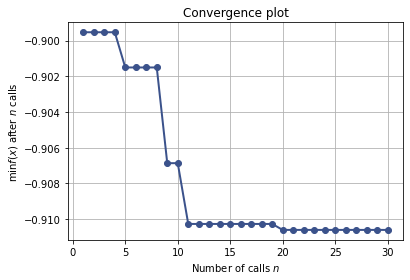

In [111]:
from skopt.plots import plot_convergence
plot_convergence(resultados_gb)

GB: Treinamento com os melhores hiper parâmetros

In [115]:
%%time
gb_model = XGBClassifier(learning_rate=0.1, max_depth=13, min_child_weight=1, gamma=0.0,
                         colsample_bytree=0.8431511329387478, use_label_encoder=False, random_state=0, n_jobs=-1)

gb_model.fit(X_train, y_train_ordinal)
preds = gb_model.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 14.6 s, sys: 28.3 ms, total: 14.6 s
Wall time: 14.6 s


In [116]:
# Retorna a acurácia
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y_test, preds)*100

90.86168521462639

In [118]:
### classification_report_extendido(y_test, preds)
# Não consegui fazer funcionar

In [120]:
# Retorna a tabela com os resultados
# digits= determina a quantidade de casas decimais pós virgula
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           1    0.92746   0.91824   0.92283      9357
           2    0.88160   0.89447   0.88799      6368

    accuracy                        0.90862     15725
   macro avg    0.90453   0.90636   0.90541     15725
weighted avg    0.90889   0.90862   0.90872     15725



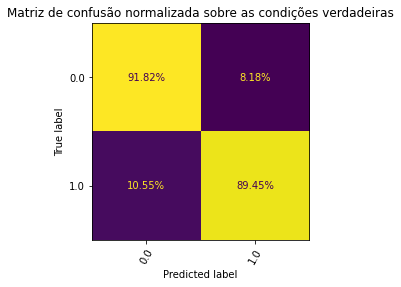

In [121]:
imprimeMatrizDeConfusão(y_test, preds, gb_model)

**▶ ANN - Rede neural**

In [122]:
# imports
from sklearn.neural_network import MLPClassifier

In [123]:
rn_model = MLPClassifier(random_state=0)
rn_model.fit(X_train, y_train.values)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=0)

In [124]:
rn_preds = rn_model.predict(X_test)

In [126]:
# Retorna a acurácia do modelo preditivo no primeiro teste
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 89.39904610492846


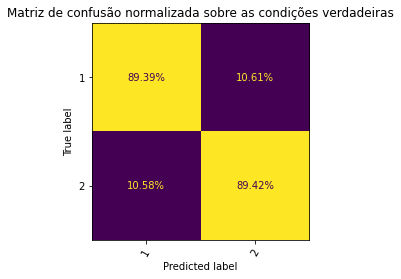

In [127]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

⚓ ANN: Busca de melhores hiperparâmetros



In [128]:
rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", verbose=0, learning_rate="adaptive", random_state=0)

In [137]:
#### Perguntar pro Caio como ele fez pra regular a busca por hiperparametro
%%time
rn_model.fit(X_train, y_train.values)
preds = rn_model.predict(X_test)

CPU times: user 2min 2s, sys: 309 ms, total: 2min 2s
Wall time: 2min 5s


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [130]:
rn_preds = rn_model.predict(X_test)

In [132]:
# Acurácia com os melhores hiperparametros
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 90.12400635930048


In [134]:
### classification_report_extendido(y_test, rn_preds)

In [135]:
# Retorna a tabela com os resultados
print(classification_report(y_test, rn_preds, digits=3))

              precision    recall  f1-score   support

           1      0.920     0.913     0.917      9357
           2      0.874     0.883     0.879      6368

    accuracy                          0.901     15725
   macro avg      0.897     0.898     0.898     15725
weighted avg      0.901     0.901     0.901     15725



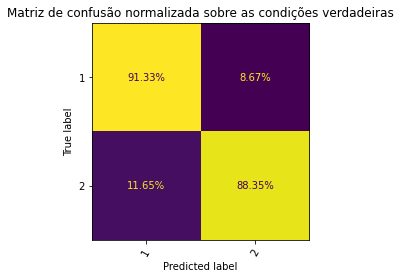

In [136]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

**▶ KNN - K-nearest neighbors**

In [138]:
# Impoorts
from sklearn.neighbors import KNeighborsClassifier

In [139]:
knn_model = KNeighborsClassifier(n_neighbors=10,  weights='distance', n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [141]:
knn_preds = knn_model.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


In [143]:
# Acurácia no primeiro teste
print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.9060095389507155


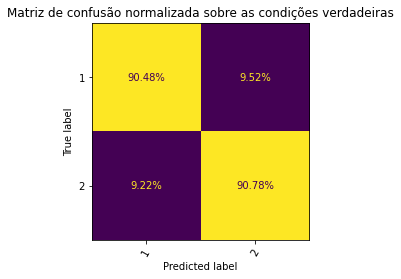

In [144]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

⚓ KNN: Busca de melhores hiperparâmetros

In [145]:
def tune_knn(params):
    n_neighbors = params[0]
    weights = params[1]
    leaf_size = params[2]
    p = params[3]
    
    print(params, '\n')
    
    knn_Model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, p=p, n_jobs=-1)
    
    knn_Model.fit(X_train, y_train)
    
    preds = knn_Model.predict(X_test)
    
    return -accuracy_score(y_test, preds)

space = [(5, 50), #n_neighbors
         ['uniform', 'distance'], # weights
         [20,30,40,50,100], # leaf_size
         [1,2]] # p

In [146]:
%%time
resultados_knn = gp_minimize(tune_knn, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[32, 'uniform', 50, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.8543
Function value obtained: -0.9011
Current minimum: -0.9011
Iteration No: 2 started. Evaluating function at random point.
[33, 'distance', 30, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.3006
Function value obtained: -0.9015
Current minimum: -0.9015
Iteration No: 3 started. Evaluating function at random point.
[17, 'distance', 50, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.7089
Function value obtained: -0.9051
Current minimum: -0.9051
Iteration No: 4 started. Evaluating function at random point.
[23, 'uniform', 30, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.8811
Function value obtained: -0.9031
Current minimum: -0.9051
Iteration No: 5 started. Evaluating function at random point.
[22, 'uniform', 30, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.8752
Function value obtained: -0.9044
Current minimum: -0.9051
Iteration No: 6 started. Evaluating function at random point.
[26, 'uniform', 40, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.4495
Function value obtained: -0.9032
Current minimum: -0.9051
Iteration No: 7 started. Evaluating function at random point.
[37, 'uniform', 40, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.1782
Function value obtained: -0.8986
Current minimum: -0.9051
Iteration No: 8 started. Evaluating function at random point.
[10, 'distance', 30, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 1.0661
Function value obtained: -0.9060
Current minimum: -0.9060
Iteration No: 9 started. Evaluating function at random point.
[15, 'distance', 30, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.4274
Function value obtained: -0.9058
Current minimum: -0.9060
Iteration No: 10 started. Evaluating function at random point.
[15, 'distance', 100, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 5.0968
Function value obtained: -0.9058
Current minimum: -0.9060
Iteration No: 11 started. Searching for the next optimal point.
[5, 'uniform', 100, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 4.3927
Function value obtained: -0.9045
Current minimum: -0.9060
Iteration No: 12 started. Searching for the next optimal point.
[50, 'distance', 100, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 5.3581
Function value obtained: -0.8989
Current minimum: -0.9060
Iteration No: 13 started. Searching for the next optimal point.
[5, 'distance', 20, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.4067
Function value obtained: -0.9017
Current minimum: -0.9060
Iteration No: 14 started. Searching for the next optimal point.
[50, 'uniform', 20, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 4.2111
Function value obtained: -0.8978
Current minimum: -0.9060
Iteration No: 15 started. Searching for the next optimal point.
[11, 'uniform', 100, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.6995
Function value obtained: -0.9055
Current minimum: -0.9060
Iteration No: 16 started. Searching for the next optimal point.
[9, 'distance', 20, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.4657
Function value obtained: -0.9046
Current minimum: -0.9060
Iteration No: 17 started. Searching for the next optimal point.
[23, 'distance', 100, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 5.0654
Function value obtained: -0.9037
Current minimum: -0.9060
Iteration No: 18 started. Searching for the next optimal point.
[12, 'distance', 100, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 5.8897
Function value obtained: -0.9047
Current minimum: -0.9060
Iteration No: 19 started. Searching for the next optimal point.
[42, 'distance', 20, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.0738
Function value obtained: -0.9012
Current minimum: -0.9060
Iteration No: 20 started. Searching for the next optimal point.
[14, 'uniform', 20, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 3.3852
Function value obtained: -0.9061
Current minimum: -0.9061
Iteration No: 21 started. Searching for the next optimal point.
[14, 'uniform', 20, 1] 



/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.3703
Function value obtained: -0.9061
Current minimum: -0.9061
Iteration No: 22 started. Searching for the next optimal point.
[5, 'uniform', 20, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.4368
Function value obtained: -0.9015
Current minimum: -0.9061
Iteration No: 23 started. Searching for the next optimal point.
[16, 'uniform', 20, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.3775
Function value obtained: -0.9041
Current minimum: -0.9061
Iteration No: 24 started. Searching for the next optimal point.
[29, 'distance', 20, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.6908
Function value obtained: -0.9013
Current minimum: -0.9061
Iteration No: 25 started. Searching for the next optimal point.
[20, 'uniform', 20, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 4.0641
Function value obtained: -0.9045
Current minimum: -0.9061
Iteration No: 26 started. Searching for the next optimal point.
[19, 'distance', 100, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.3108
Function value obtained: -0.9054
Current minimum: -0.9061
Iteration No: 27 started. Searching for the next optimal point.
[45, 'uniform', 100, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.3213
Function value obtained: -0.8974
Current minimum: -0.9061
Iteration No: 28 started. Searching for the next optimal point.
[38, 'uniform', 100, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 5.9851
Function value obtained: -0.9003
Current minimum: -0.9061
Iteration No: 29 started. Searching for the next optimal point.
[46, 'uniform', 20, 1] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 6.0963
Function value obtained: -0.8986
Current minimum: -0.9061
Iteration No: 30 started. Searching for the next optimal point.
[41, 'distance', 100, 2] 



/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.0491
Function value obtained: -0.9005
Current minimum: -0.9061
CPU times: user 2min 33s, sys: 6.4 s, total: 2min 40s
Wall time: 1min 46s


In [148]:
# Melhores resultados
# Em ordem: n_neighbors, weights, leaf_size, p=1
resultados_knn.x

[14, 'uniform', 20, 1]

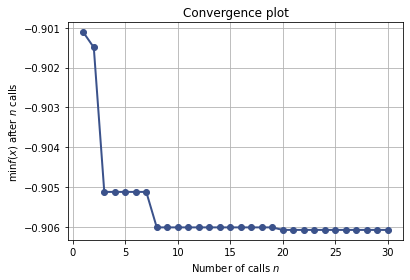

In [149]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

KNN: Treinamento com os melhores hiperparâmetros

In [151]:
# Treinamento dos modelos preditivos.
# Inserir manualmente os melhores hiperparametros
%%time
knn_model = KNeighborsClassifier(n_neighbors=14, weights='uniform', leaf_size=20, p=1, n_jobs=-1)

knn_model.fit(X_train, y_train)
preds = knn_model.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  ):


CPU times: user 4.97 s, sys: 46.9 ms, total: 5.01 s
Wall time: 3.18 s


In [152]:
# Acurácia com os melhores hiperparametros
accuracy_score(y_test, preds)*100

90.60731319554849

In [ ]:
#### classification_report_extendido(y_test, preds)
# Não funciona

In [153]:
# Retorna a tabela com os resultados
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           1    0.93325   0.90702   0.91995      9357
           2    0.86880   0.90468   0.88638      6368

    accuracy                        0.90607     15725
   macro avg    0.90103   0.90585   0.90316     15725
weighted avg    0.90715   0.90607   0.90635     15725



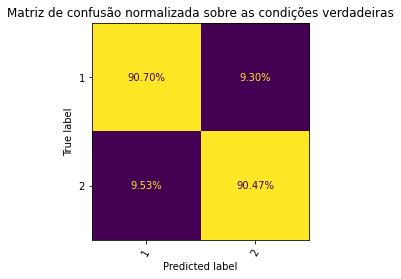

In [154]:
imprimeMatrizDeConfusão(y_test, preds, knn_model)